In [267]:
import os
from PIL import Image

In [307]:
fd = "/home/jupyter/ai_font/data/exp0820/report/over/플레이브밤비"
files = sorted([f for f in os.listdir(fd) if f.endswith(".png")])

In [308]:
len(files)

214

In [309]:
files

['플레이브밤비__over__갊_갦.png',
 '플레이브밤비__over__갊_걂.png',
 '플레이브밤비__over__갊_긺.png',
 '플레이브밤비__over__갸_가.png',
 '플레이브밤비__over__갸_개.png',
 '플레이브밤비__over__갸_기.png',
 '플레이브밤비__over__닠_낰.png',
 '플레이브밤비__over__닠_냌.png',
 '플레이브밤비__over__닠_냨.png',
 '플레이브밤비__over__닦_댂.png',
 '플레이브밤비__over__닦_댞.png',
 '플레이브밤비__over__닦_딖.png',
 '플레이브밤비__over__돛_독.png',
 '플레이브밤비__over__돛_돆.png',
 '플레이브밤비__over__돛_돇.png',
 '플레이브밤비__over__돛_돈.png',
 '플레이브밤비__over__돛_돉.png',
 '플레이브밤비__over__돛_돊.png',
 '플레이브밤비__over__돛_돋.png',
 '플레이브밤비__over__돛_돌.png',
 '플레이브밤비__over__돛_돍.png',
 '플레이브밤비__over__돛_돎.png',
 '플레이브밤비__over__돛_돏.png',
 '플레이브밤비__over__돛_돐.png',
 '플레이브밤비__over__돛_돒.png',
 '플레이브밤비__over__돛_돓.png',
 '플레이브밤비__over__돛_돔.png',
 '플레이브밤비__over__돛_돖.png',
 '플레이브밤비__over__돛_돗.png',
 '플레이브밤비__over__돛_돘.png',
 '플레이브밤비__over__땍_딱.png',
 '플레이브밤비__over__땍_땎.png',
 '플레이브밤비__over__땍_땏.png',
 '플레이브밤비__over__땍_땐.png',
 '플레이브밤비__over__땍_땑.png',
 '플레이브밤비__over__땍_땒.png',
 '플레이브밤비__over__땍_땓.png',
 '플레이브밤비__over__땍_땔.png',
 '플레이브밤비__ov

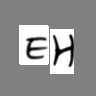

In [315]:
Image.open(f"{fd}/{files[-6]}")

In [18]:
files[11]

'플레이브밤비__over__띡.png'